#### This script provides the framework used for doing a villus segmentation on a MERSCOPE experiment

In [1]:
import imageio as io
import os
import PIL
import cv2
import matplotlib.pyplot as plt
import glob
import numpy as np
import scanpy as sc
from tqdm.notebook import tqdm
PIL.Image.MAX_IMAGE_PIXELS = 4902390226

#### Path to the MERSCOPE output folder

In [2]:
merscope_path = 'D:/amonell/merscope_final/SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8'

In [3]:
if_channel_cell_boundary = io.imread(os.path.join(merscope_path, f'images', 'mosaic_PolyT_z3.tif'))

C:\Users\amonell\AppData\Local\Temp\3\ipykernel_39768\3488714977.py:1: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  if_channel_cell_boundary = io.imread(os.path.join(merscope_path, f'images', 'mosaic_PolyT_z3.tif'))


##### Downsizing and visualization of the PolyT staining from the MERSCOPE output.

In [4]:
# Read the image
downsize_factor = 5
pad_height = (downsize_factor - if_channel_cell_boundary.shape[0] % downsize_factor) % downsize_factor
pad_width = (downsize_factor - if_channel_cell_boundary.shape[1] % downsize_factor) % downsize_factor

# Pad the array with zeros
padded_array = np.pad(if_channel_cell_boundary, ((0, pad_height), (0, pad_width)), mode='constant')

new_width = int(padded_array.shape[1] /downsize_factor) 
new_height = int(padded_array.shape[0] / downsize_factor)

image = cv2.resize(padded_array.astype(np.float32), (new_width, new_height))


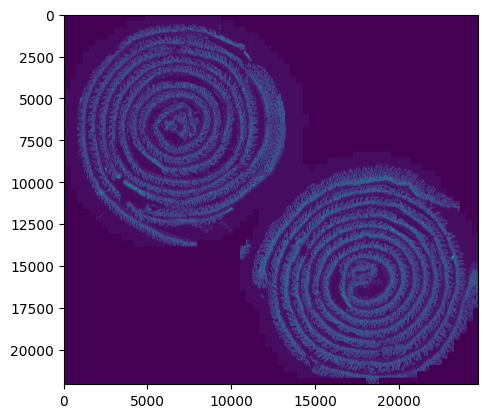

In [5]:
plt.imshow(image)
plt.show()

In [6]:
try:
    os.mkdir(os.path.join(merscope_path, 'villi_images'))
except:
    print('Villi images directory already made')

##### Chunking the images so that a model can be trained on subsections in Cellpose

In [10]:
chunk_size = (4000, 4000)

for i in range(0, image.shape[1], int(chunk_size[1]/2)):
    for j in range(0, image.shape[0], int(chunk_size[0]/2)):
        # Define the coordinates for cropping
        left = i
        upper = j
        right = i + chunk_size[1]
        lower = j + chunk_size[0]

        # Crop the image chunk
        chunk = image[upper:lower, left:right]

        cv2.imwrite(os.path.join(merscope_path, 'villi_images', f'chunk_{i}_{j}.png'), ((chunk/np.max(chunk))*255).astype(int))

C:\Users\amonell\AppData\Local\Temp\3\ipykernel_46444\1742931772.py:14: RuntimeWarning: invalid value encountered in divide
  cv2.imwrite(os.path.join(merscope_path, 'villi_images', f'chunk_{i}_{j}.png'), ((chunk/np.max(chunk))*255).astype(int))
C:\Users\amonell\AppData\Local\Temp\3\ipykernel_46444\1742931772.py:14: RuntimeWarning: invalid value encountered in cast
  cv2.imwrite(os.path.join(merscope_path, 'villi_images', f'chunk_{i}_{j}.png'), ((chunk/np.max(chunk))*255).astype(int))


##### Running Cellpose on the chunks

In [6]:
cellpose_model_path = r'D:/amonell/merscope_final/SI-Ctrl-L-RAR-R-dist-1-VS120-NP_Beta8/villi_images/models/CP_20231111_162456'

In [7]:
from cellpose import models
from cellpose import io as cio
model = models.CellposeModel(gpu=True, pretrained_model= cellpose_model_path)
channels = [0,0]
masks_, flows_, styles_= model.eval([((image/np.max(image))*255).astype(int)], channels=channels, diameter=392.78,flow_threshold=0.4, cellprob_threshold=0)


##### Saving out the results

In [8]:
np.save(os.path.join(merscope_path, 'villi_segmentation_mask.npy'), masks_[0])

In [9]:
np.save(os.path.join(merscope_path, 'villi_segmentation_downsize_factor.npy'), np.array([downsize_factor]))

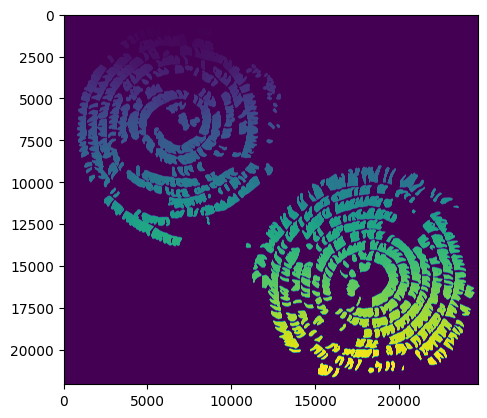

In [10]:
plt.imshow(masks_[0])
plt.show()